In [81]:
import wapi # wattsights egen pakke / den må installers via `pip install wapi-python`
import pandas as pd
import os
import numpy as np
from datetime import datetime 
from datetime import timedelta

# Create a session
# Dette forutsetter at dere har lagret volue credentials som miljøvariabler på PC'en deres og med navnet `WS_CLIENT_ID` og `WS_CLIENT_SECRET`
user = os.getenv("WS_CLIENT_ID")
password = os.getenv("WS_CLIENT_SECRET")
session = wapi.Session(client_id=user, client_secret=password)

start = '2020-01-01'
end = '2021-01-01'
periods=pd.date_range(start,end,freq='D')

curves = ['con no5 mwh/h cet min15 a',
'tt no5 con ec00 °c cet min15 f',
'cc no5 con ec00 % cet min15 f',
]

df_watt = pd.DataFrame()
for curve in curves:
    print(f"Working with {curve}")
    curve = session.get_curve(name=curve)
    curve_type = curve.curve_type
    res = []
    counter = 1
    if curve_type == 'TIME_SERIES':
        ts = curve.get_data(data_from=start, data_to=end, function='SAVERAGE', frequency='H')
        watt_temp = ts.to_pandas()
        df_watt = pd.merge(df_watt, watt_temp, left_index=True, right_index=True, how='outer')
        continue
    
    for j in range(len(periods)):
        if j == len(periods)-1:
            continue
        if curve_type == 'TAGGED_INSTANCES':
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='H', tags=['Avg'])
        else: #curve_type == 'INSTANCES'
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='H')
        # check if ts_list is empty and if yes, jump over that timestamp
        if not ts_list:
            continue
        pd_s = ts_list[0].to_pandas()
        if pd_s.empty:
            continue
        pd_s = pd_s.sort_index(ascending=True)
        pd_s = pd_s[:24]
        res.append(pd_s)
        print(f'Done {counter} out of {len(periods)}')
        counter += 1

    for k in range(len(res)):
        if k == 0:
            watt = pd.Series(res[k])
        else:
            watt = pd.concat([watt, res[k]])
    watt_temp = watt.rename(curve)
    df_watt = pd.merge(df_watt, watt_temp, left_index=True, right_index=True, how='outer')

Working with con no5 mwh/h cet min15 a
Working with tt no5 con ec00 °c cet min15 f
Done 1 out of 367
Done 2 out of 367
Done 3 out of 367
Done 4 out of 367
Done 5 out of 367
Done 6 out of 367
Done 7 out of 367
Done 8 out of 367
Done 9 out of 367
Done 10 out of 367
Done 11 out of 367
Done 12 out of 367
Done 13 out of 367
Done 14 out of 367
Done 15 out of 367
Done 16 out of 367
Done 17 out of 367
Done 18 out of 367
Done 19 out of 367
Done 20 out of 367
Done 21 out of 367
Done 22 out of 367
Done 23 out of 367
Done 24 out of 367
Done 25 out of 367
Done 26 out of 367
Done 27 out of 367
Done 28 out of 367
Done 29 out of 367
Done 30 out of 367
Done 31 out of 367
Done 32 out of 367
Done 33 out of 367
Done 34 out of 367
Done 35 out of 367
Done 36 out of 367
Done 37 out of 367
Done 38 out of 367
Done 39 out of 367
Done 40 out of 367
Done 41 out of 367
Done 42 out of 367
Done 43 out of 367
Done 44 out of 367
Done 45 out of 367
Done 46 out of 367
Done 47 out of 367
Done 48 out of 367
Done 49 out of

In [82]:
df_watt.columns = ["cons_actual", "temp_forecast", "wind_forecast"]
df_watt_safecopy = df_watt #in case i fuck up :)
df_watt.dropna(inplace=True)
df_watt['Seconds'] = df_watt.index.map(pd.Timestamp.timestamp)
day = 60*60*24
year = 365.2425*day
week = day*7

df_watt['Day sin'] = np.sin(df_watt['Seconds'] * (2* np.pi / day))
df_watt['Day cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / day))
df_watt['Week sin'] = np.sin(df_watt['Seconds'] * (2 * np.pi / week))
df_watt['Week cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / week))
df_watt['Year sin'] = np.sin(df_watt['Seconds'] * (2 * np.pi / year))
df_watt['Year cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / year))

df_watt=df_watt.drop(['Seconds'], axis=1)

cols = list(df_watt)[1:]
#New dataframe with only training data - 4 columns
df_for_training = df_watt[cols].astype(float)
df_for_training

,temp_forecast,wind_forecast,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
2020-01-01 00:00:00+01:00,6.7,0.98,-2.588190e-01,9.659258e-01,-0.804598,0.593820,-2.867126e-03,0.999996
2020-01-01 01:00:00+01:00,6.7,0.98,-7.670342e-12,1.000000e+00,-0.781831,0.623490,-2.150345e-03,0.999998
2020-01-01 02:00:00+01:00,7.0,0.99,2.588190e-01,9.659258e-01,-0.757972,0.652287,-1.433564e-03,0.999999
2020-01-01 03:00:00+01:00,6.7,0.99,5.000000e-01,8.660254e-01,-0.733052,0.680173,-7.167823e-04,1.000000
2020-01-01 04:00:00+01:00,6.6,0.98,7.071068e-01,7.071068e-01,-0.707107,0.707107,1.964387e-15,1.000000
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+01:00,-2.0,0.79,-1.000000e+00,-3.448707e-12,0.623490,0.781831,6.580015e-03,0.999978
2020-12-31 20:00:00+01:00,-2.4,0.74,-9.659258e-01,2.588190e-01,0.652287,0.757972,7.296780e-03,0.999973
2020-12-31 21:00:00+01:00,-2.8,0.56,-8.660254e-01,5.000000e-01,0.680173,0.733052,8.013541e-03,0.999968
2020-12-31 22:00:00+01:00,-3.1,0.35,-7.071068e-01,7.071068e-01,0.707107,0.707107,8.730298e-03,0.999962


In [83]:
import catboost as cb
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [84]:
X = df_watt[cols]
y = df_watt['cons_actual']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE')

grid = {
    'iterations': [100, 150, 200],
    'learning_rate': [0.03, 0.1],
    'depth': [2, 4, 6, 8],
    'l2_leaf_reg': [0.2, 0.5, 1, 3]
}

model.grid_search(grid, train_dataset)

0:	learn: 1849.9399217	test: 1835.5060586	best: 1835.5060586 (0)	total: 2.94ms	remaining: 291ms
1:	learn: 1795.3756029	test: 1781.1338716	best: 1781.1338716 (1)	total: 4.56ms	remaining: 223ms
2:	learn: 1742.4051024	test: 1728.2758985	best: 1728.2758985 (2)	total: 5.7ms	remaining: 184ms
3:	learn: 1691.0451322	test: 1676.9307201	best: 1676.9307201 (3)	total: 6.81ms	remaining: 163ms
4:	learn: 1641.1712185	test: 1627.3142242	best: 1627.3142242 (4)	total: 7.75ms	remaining: 147ms
5:	learn: 1592.6826605	test: 1578.8548684	best: 1578.8548684 (5)	total: 8.7ms	remaining: 136ms
6:	learn: 1545.7968766	test: 1532.0725147	best: 1532.0725147 (6)	total: 9.61ms	remaining: 128ms
7:	learn: 1500.9975266	test: 1487.1688516	best: 1487.1688516 (7)	total: 10.5ms	remaining: 121ms
8:	learn: 1457.6086511	test: 1443.7427518	best: 1443.7427518 (8)	total: 11.4ms	remaining: 115ms
9:	learn: 1415.4941515	test: 1401.5984963	best: 1401.5984963 (9)	total: 12.3ms	remaining: 110ms
10:	learn: 1373.6503692	test: 1360.0584376

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [85]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing Performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing Performance
RMSE: 42.32
R2: 0.98


<BarContainer object of 8 artists>

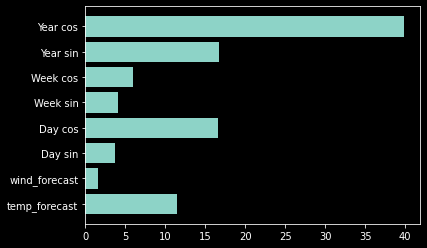

In [86]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.style.use('dark_background')
plt.barh(df_watt.columns[1:], model.feature_importances_)

# predict the future

In [87]:
import wapi # wattsights egen pakke / den må installers via `pip install wapi-python`
import pandas as pd
import os
import numpy as np
from datetime import datetime 
from datetime import timedelta

# Create a session
# Dette forutsetter at dere har lagret volue credentials som miljøvariabler på PC'en deres og med navnet `WS_CLIENT_ID` og `WS_CLIENT_SECRET`
user = os.getenv("WS_CLIENT_ID")
password = os.getenv("WS_CLIENT_SECRET")
session = wapi.Session(client_id=user, client_secret=password)

start = '2021-01-01'
end = '2021-01-03'
periods=pd.date_range(start,end,freq='D')

curves = ['con no5 mwh/h cet min15 a',
'tt no5 con ec00 °c cet min15 f',
'cc no5 con ec00 % cet min15 f',
'con no5 ec00 mwh/h cet min15 f'
]

df_watt2 = pd.DataFrame()
for curve in curves:
    print(f"Working with {curve}")
    curve = session.get_curve(name=curve)
    curve_type = curve.curve_type
    res = []
    counter = 1
    if curve_type == 'TIME_SERIES':
        ts = curve.get_data(data_from=start, data_to=end, function='SAVERAGE', frequency='H')
        watt_temp = ts.to_pandas()
        df_watt2 = pd.merge(df_watt2, watt_temp, left_index=True, right_index=True, how='outer')
        continue
    
    for j in range(len(periods)):
        if j == len(periods)-1:
            continue
        if curve_type == 'TAGGED_INSTANCES':
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='H', tags=['Avg'])
        else: #curve_type == 'INSTANCES'
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='H')
        # check if ts_list is empty and if yes, jump over that timestamp
        if not ts_list:
            continue
        pd_s = ts_list[0].to_pandas()
        if pd_s.empty:
            continue
        pd_s = pd_s.sort_index(ascending=True)
        pd_s = pd_s[:24]
        res.append(pd_s)
        print(f'Done {counter} out of {len(periods)}')
        counter += 1

    for k in range(len(res)):
        if k == 0:
            watt = pd.Series(res[k])
        else:
            watt = pd.concat([watt, res[k]])
    watt_temp = watt.rename(curve)
    df_watt2 = pd.merge(df_watt2, watt_temp, left_index=True, right_index=True, how='outer')

Working with con no5 mwh/h cet min15 a
Working with tt no5 con ec00 °c cet min15 f
Done 1 out of 3
Done 2 out of 3
Working with cc no5 con ec00 % cet min15 f
Done 1 out of 3
Done 2 out of 3
Working with con no5 ec00 mwh/h cet min15 f
Done 1 out of 3
Done 2 out of 3


In [88]:
df_watt2.columns = ["cons_actual", "temp_forecast", "wind_forecast", "cons_forecast"]
df_watt2

,cons_actual,temp_forecast,wind_forecast,cons_forecast
2021-01-01 00:00:00+01:00,2202.0,-1.7,0.35,2290.037793
2021-01-01 01:00:00+01:00,2209.0,-2.0,0.21,2239.877358
2021-01-01 02:00:00+01:00,2158.0,-1.3,0.44,2182.317211
2021-01-01 03:00:00+01:00,2130.0,-1.6,0.26,2164.740903
2021-01-01 04:00:00+01:00,2175.0,-2.1,0.17,2175.900600
2021-01-01 05:00:00+01:00,2187.0,-2.4,0.18,2166.765643
2021-01-01 06:00:00+01:00,2263.0,-2.6,0.23,2172.234392
2021-01-01 07:00:00+01:00,2297.0,-2.9,0.24,2232.920350
2021-01-01 08:00:00+01:00,2325.0,-3.3,0.20,2279.413454
2021-01-01 09:00:00+01:00,2350.0,-3.7,0.16,2397.899299


In [89]:

df_watt2.dropna(inplace=True)
df_watt2['Seconds'] = df_watt2.index.map(pd.Timestamp.timestamp)
day = 60*60*24
year = 365.2425*day
week = day*7

df_watt2['Day sin'] = np.sin(df_watt2['Seconds'] * (2* np.pi / day))
df_watt2['Day cos'] = np.cos(df_watt2['Seconds'] * (2 * np.pi / day))
df_watt2['Week sin'] = np.sin(df_watt2['Seconds'] * (2 * np.pi / week))
df_watt2['Week cos'] = np.cos(df_watt2['Seconds'] * (2 * np.pi / week))
df_watt2['Year sin'] = np.sin(df_watt2['Seconds'] * (2 * np.pi / year))
df_watt2['Year cos'] = np.cos(df_watt2['Seconds'] * (2 * np.pi / year))

df_watt2=df_watt2.drop(['Seconds'], axis=1)

cols = list(df_watt2)[0:11]
#New dataframe with only training data - 4 columns
df_for_training2 = df_watt2[cols].astype(float)
df_watt2

,cons_actual,temp_forecast,wind_forecast,cons_forecast,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
2021-01-01 00:00:00+01:00,2202.0,-1.7,0.35,2290.037793,-2.588190e-01,9.659258e-01,0.757972,6.522874e-01,0.010164,0.999948
2021-01-01 01:00:00+01:00,2209.0,-2.0,0.21,2239.877358,-6.012051e-12,1.000000e+00,0.781831,6.234898e-01,0.010881,0.999941
2021-01-01 02:00:00+01:00,2158.0,-1.3,0.44,2182.317211,2.588190e-01,9.659258e-01,0.804598,5.938202e-01,0.011597,0.999933
2021-01-01 03:00:00+01:00,2130.0,-1.6,0.26,2164.740903,5.000000e-01,8.660254e-01,0.826239,5.633201e-01,0.012314,0.999924
2021-01-01 04:00:00+01:00,2175.0,-2.1,0.17,2175.900600,7.071068e-01,7.071068e-01,0.846724,5.320321e-01,0.013031,0.999915
2021-01-01 05:00:00+01:00,2187.0,-2.4,0.18,2166.765643,8.660254e-01,5.000000e-01,0.866025,5.000000e-01,0.013747,0.999905
2021-01-01 06:00:00+01:00,2263.0,-2.6,0.23,2172.234392,9.659258e-01,2.588190e-01,0.884115,4.672686e-01,0.014464,0.999895
2021-01-01 07:00:00+01:00,2297.0,-2.9,0.24,2232.920350,1.000000e+00,8.575395e-12,0.900969,4.338837e-01,0.015181,0.999885
2021-01-01 08:00:00+01:00,2325.0,-3.3,0.20,2279.413454,9.659258e-01,-2.588190e-01,0.916562,3.998920e-01,0.015898,0.999874
2021-01-01 09:00:00+01:00,2350.0,-3.7,0.16,2397.899299,8.660254e-01,-5.000000e-01,0.930874,3.653410e-01,0.016614,0.999862


['temp_forecast', 'wind_forecast', 'cons_forecast', 'Day sin', 'Day cos', 'Week sin', 'Week cos', 'Year sin', 'Year cos']


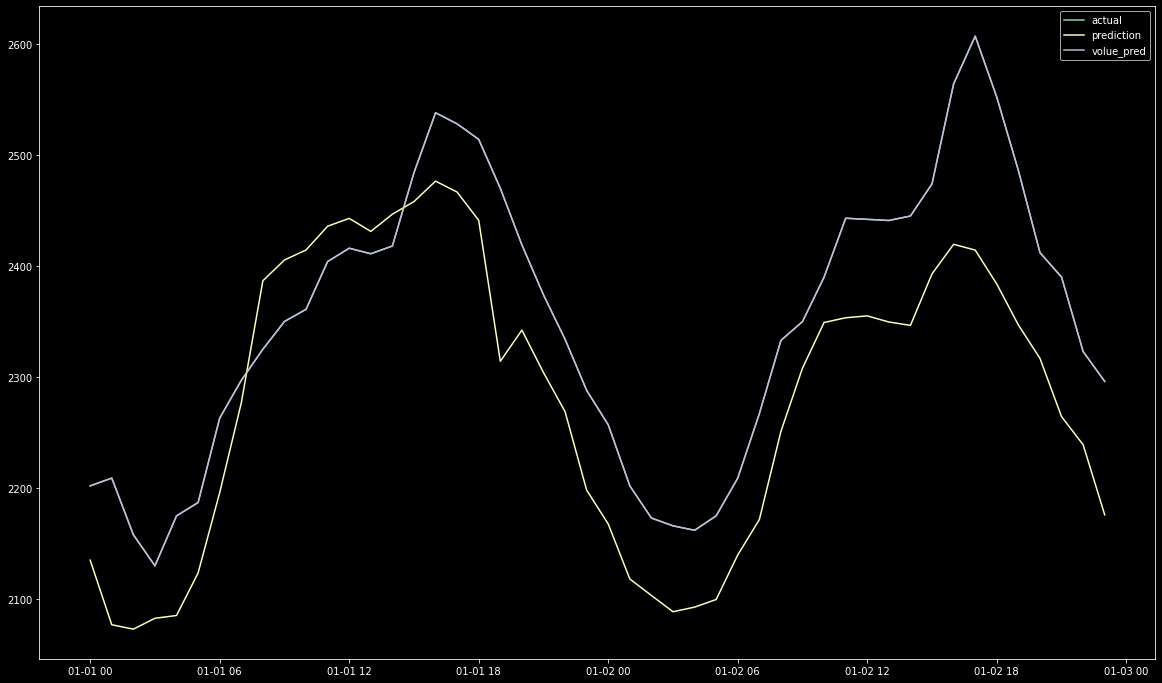

In [90]:
cols = list(df_watt2)[1:]
print(cols)
X_val = df_watt2[cols]
y_val = df_watt2['cons_actual']
pred_future = model.predict(X_val)
"""rmse = (np.sqrt(mean_squared_error(y_val, pred)))
r2 = r2_score(y_val, pred)"""
dates = df_watt2.index
plt.figure(figsize=(20,12))
plt.plot(y_val, label='actual')
plt.plot(dates, pred_future, label='prediction')
plt.plot(df_watt2['cons_actual'], label='volue_pred')
plt.legend()

In [91]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

data = df_watt2[cols]
target = df_watt2['cons_actual']

#
# Create Training and Test Split
#
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42, test_size=0.1)
#
# Standardize the dataset
#
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
#
# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 1000,
            'max_depth': 4,
            'min_samples_split': 3,
            'learning_rate': 0.01,
            'loss': 'squared_error'}
gbr = GradientBoostingRegressor(**gbr_params)
gbr.fit(X_train_std, y_train)

# Print Coefficient of determination R^2
#
print("Model Accuracy: %.3f" % gbr.score(X_test_std, y_test))
#
# Create the mean squared error
#
mse = mean_squared_error(y_test, gbr.predict(X_test_std))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.991
The mean squared error (MSE) on test set: 253.4576


In [92]:
gbr_pred = gbr.predict(X_val)


c:\Users\57861\.conda\envs\p39_sommer\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


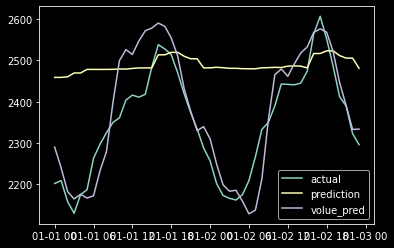

In [94]:
plt.plot(y_val, label='actual')
plt.plot(dates, gbr_pred, label='prediction')
plt.plot(df_watt2['cons_forecast'], label='volue_pred')
plt.legend()

# LGBM Regressor

In [97]:
import lightgbm as lgb
lgbm = lgb.LGBMRegressor(
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=20
)

lgbm.fit(X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='l1',
    callbacks=[lgb.early_stopping(5)]
    )
lgbm_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)
rmse_test = mean_squared_error(y_test, lgbm_pred)**0.5
print(f'The RMSE of prediction is: {rmse_test}')

# feature importances
print(f'Feature importances: {list(lgbm.feature_importances_)}')


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 357.818	valid_0's l2: 181673
The RMSE of prediction is: 426.2311828311996
Feature importances: [65, 6, 1, 381, 1, 26, 16, 13, 66, 25]


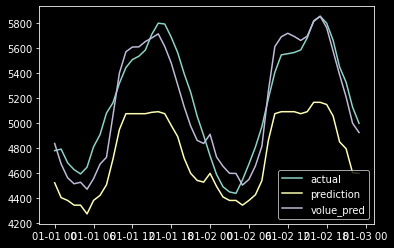

In [98]:
lgbm_pred_future = lgbm.predict(X_val, num_iteration=lgbm.best_iteration_)
plt.plot(y_val, label='actual')
plt.plot(dates, lgbm_pred_future, label='prediction')
plt.plot(df_watt2['cons_forecast'], label='volue_pred')
plt.legend()

# pretty bad

# NuSVR

In [99]:
from sklearn.svm import NuSVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale

nu_X = scale(X_train)
nu_y = scale(y_train)
nu_X_train, nu_X_test, nu_y_train, nu_y_test = train_test_split(nu_X, nu_y, test_size=0.15)

nsvr = NuSVR()
nsvr.fit(nu_X_train, nu_y_train)
score = nsvr.score(nu_X_train, nu_y_train)
print("R2 score: ", score)
cv_score = cross_val_score(nsvr, nu_X, nu_y, cv=10)
print("CV mean score: ", cv_score.mean())


R2 score:  0.9888544084190221
CV mean score:  0.9873773621172633


c:\Users\57859\.conda\envs\MachineLearning\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but NuSVR was fitted without feature names
  warnings.warn(


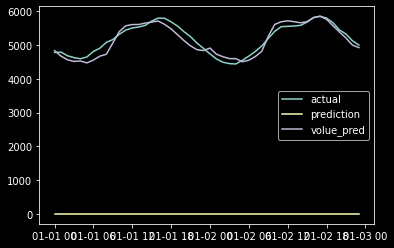

In [102]:
nusvr_pred_future = nsvr.predict(X_val)
plt.plot(y_val, label='actual')
plt.plot(dates, nusvr_pred_future, label='prediction')
plt.plot(df_watt2['cons_forecast'], label='volue_pred')
plt.legend()
